### Part 1: Data Cleaning

In [1]:
# %pip install kagglehub
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install ipywidgets
# %pip install scikit-learn
# %pip install torch

In [2]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# Download latest version
path = kagglehub.dataset_download("gauravkumar2525/kepler-exoplanet-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/ciprian/.cache/kagglehub/datasets/gauravkumar2525/kepler-exoplanet-dataset/versions/1


In [4]:
# Load the dataset
df = pd.read_csv(path + "/exoplanets_data.csv")
print("Loaded dataset shape:", df.shape)
df.describe()

Loaded dataset shape: (9564, 12)


,kepid,koi_disposition,koi_score,koi_period,koi_prad,koi_teq,koi_insol,koi_steff,koi_srad,koi_slogg,koi_kepmag
count,9.564000e+03,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9.564000e+03,9564.00000,9564.000000,9564.000000,9564.000000
mean,7.690628e+06,0.780845,0.480829,75.671358,102.891778,1085.385828,7.745737e+03,5706.82328,1.728712,4.310157,14.264606
std,2.653459e+06,0.863026,0.437658,1334.744046,3018.662296,839.940895,1.565099e+05,781.58775,6.009769,0.424316,1.385376
min,7.574500e+05,0.000000,0.000000,0.241843,0.080000,25.000000,0.000000e+00,2661.00000,0.109000,0.047000,6.966000
25%,5.556034e+06,0.000000,0.000000,2.733684,1.430000,553.000000,2.216000e+01,5333.00000,0.835750,4.232750,13.440000
50%,7.906892e+06,0.000000,0.480829,9.752831,2.490000,906.000000,1.583200e+02,5745.00000,1.006500,4.432000,14.520000
75%,9.873066e+06,2.000000,0.995000,40.715178,21.712500,1352.500000,1.110257e+03,6099.00000,1.435250,4.539000,15.322000
max,1.293514e+07,2.000000,1.000000,129995.778400,200346.000000,14667.000000,1.094755e+07,15896.00000,229.908000,5.364000,20.003000


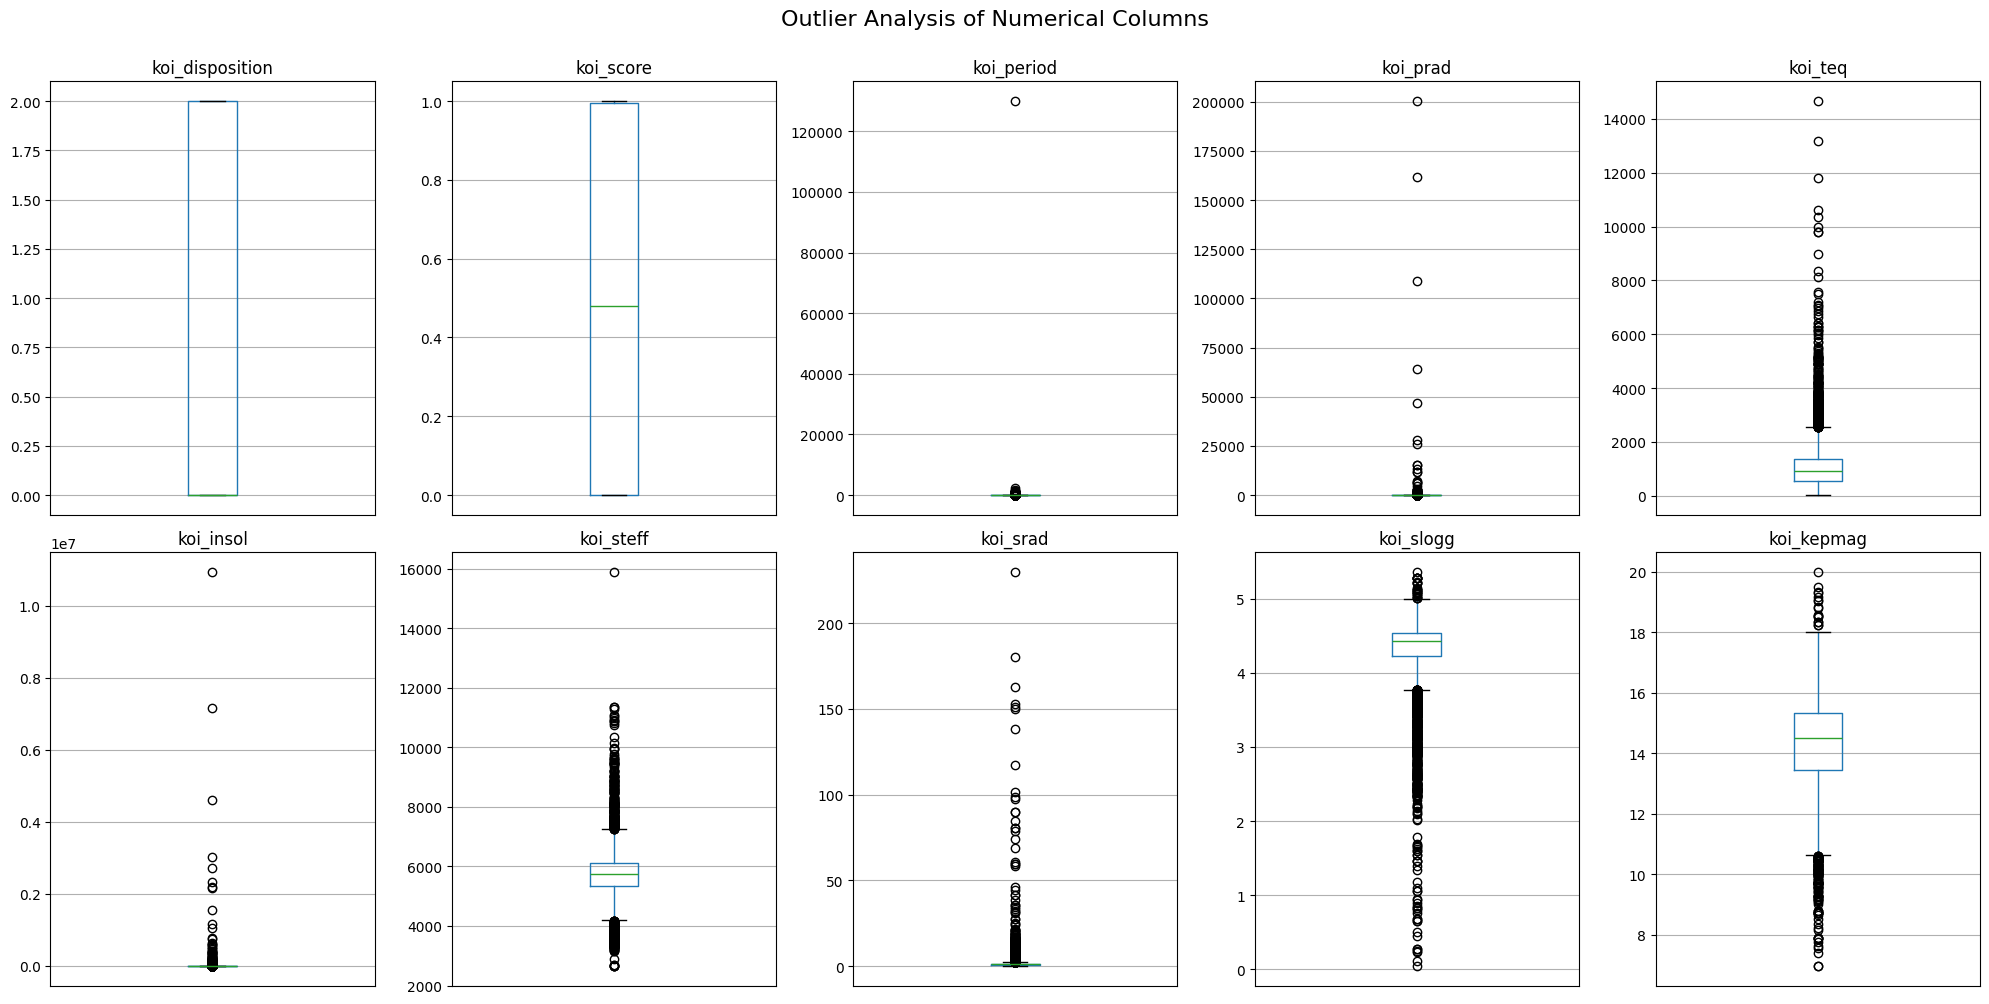

In [5]:
def plot_outliers(df, nrows, ncols, figsize):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    fig.suptitle("Outlier Analysis of Numerical Columns", fontsize=16, y=1)

    # Flatten axes for easier indexing
    axes = axes.flatten()

    # Plot boxplots for each numerical column
    for i, col in enumerate(df.columns):
        df.boxplot(column=col, ax=axes[i])
        axes[i].set_title(col)
        axes[i].set_xticks([])

    plt.tight_layout()
    plt.show()

# Plot outliers
plot_outliers(df.select_dtypes(include=["float64", "int64"]).drop("kepid", axis=1), 2, 5, (20, 10))

In [6]:
def detect_outliers_iqr(df, column, factor=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    is_outlier = (df[column] < (Q1 - factor * IQR)) | (df[column] > (Q3 + factor * IQR))
    return is_outlier

# Detect and mark outliers for each numerical column
for col in df.select_dtypes(include=["float64", "int64"]).drop(["kepid", "koi_disposition", "koi_score"], axis=1).columns:
    df[col + "_outlier"] = detect_outliers_iqr(df, col)
    print(f"Outliers detected in {col}: {df[col + '_outlier'].sum()} out of {df.shape[0]} rows")

Outliers detected in koi_period: 1567 out of 9564 rows
Outliers detected in koi_prad: 1304 out of 9564 rows
Outliers detected in koi_teq: 450 out of 9564 rows
Outliers detected in koi_insol: 1555 out of 9564 rows
Outliers detected in koi_steff: 595 out of 9564 rows
Outliers detected in koi_srad: 833 out of 9564 rows
Outliers detected in koi_slogg: 734 out of 9564 rows
Outliers detected in koi_kepmag: 156 out of 9564 rows


In [7]:
# Remove the outliers from the main dataset
outlier_columns = [col for col in df.columns if col.endswith("_outlier")]

df_clean_no_transform = df[~df[outlier_columns].any(axis=1)]

print("Cleaned dataset shape without transforms:", df_clean_no_transform.shape)

Cleaned dataset shape without transforms: (5449, 20)


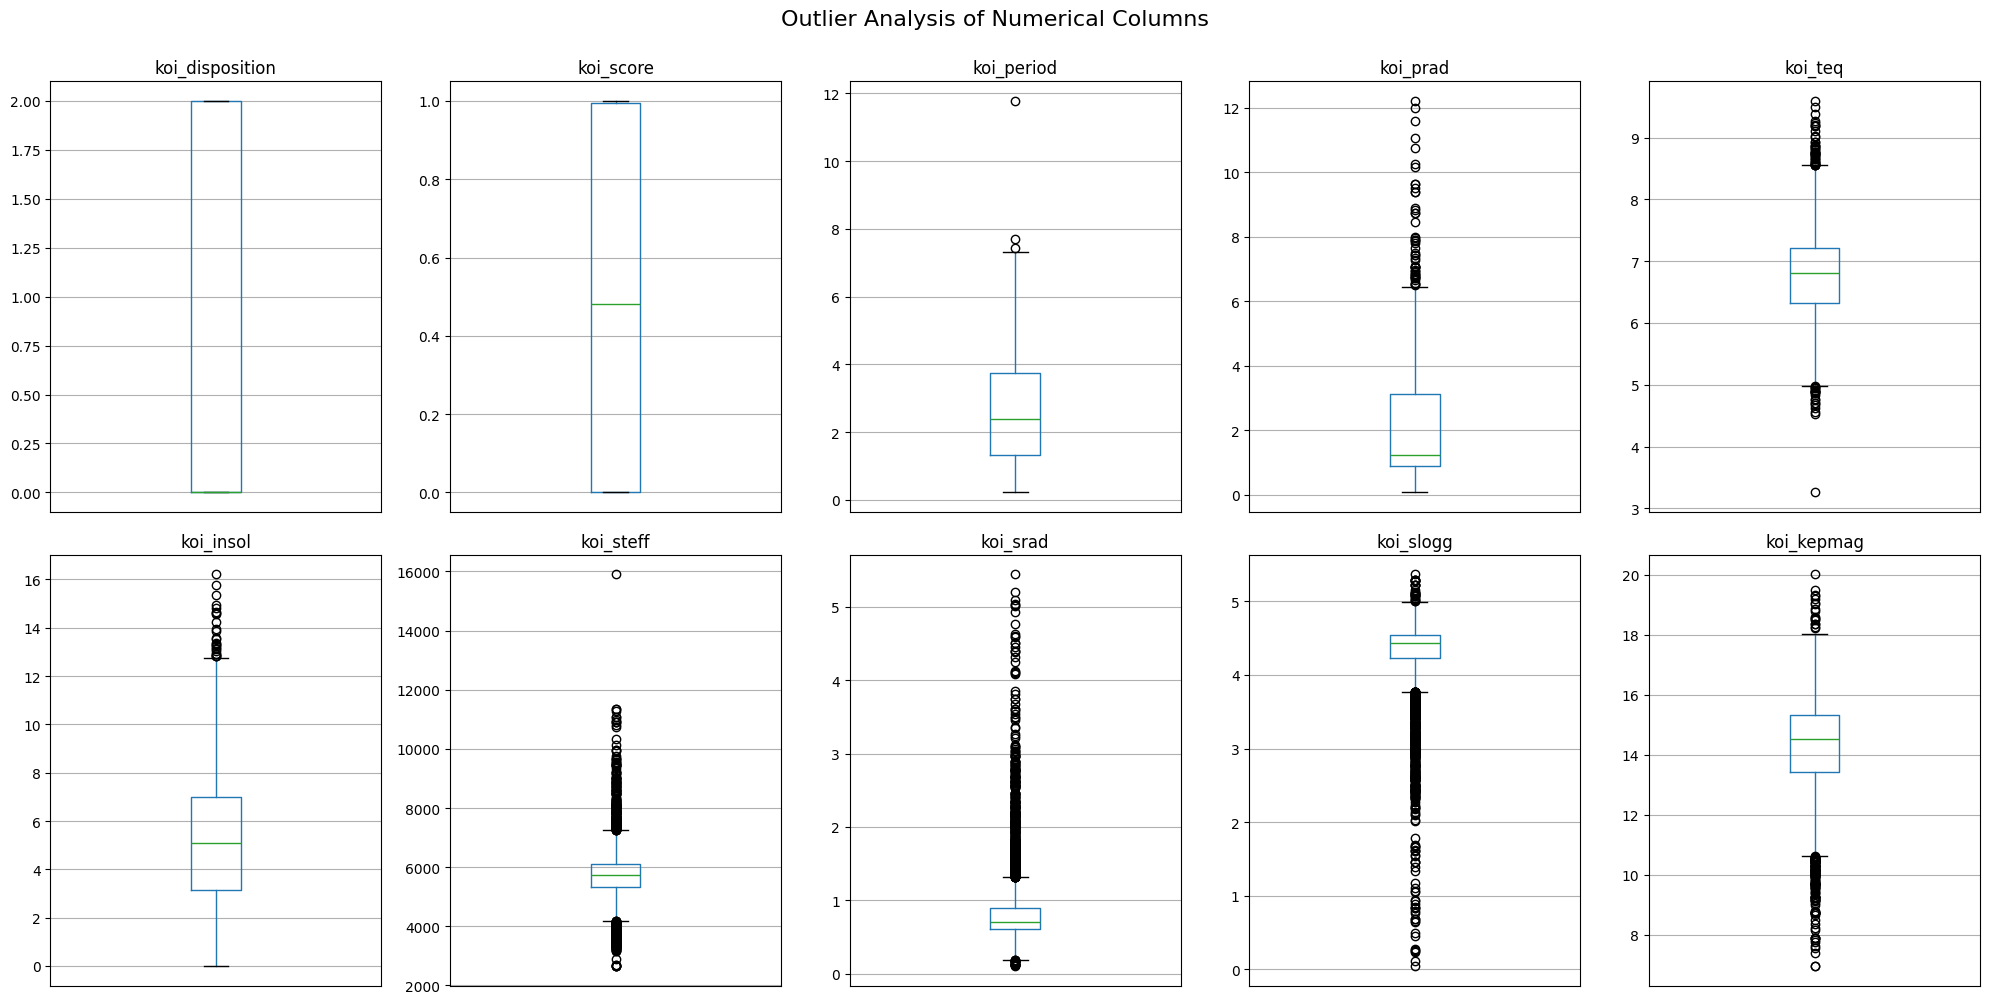

In [8]:
# Apply log1p for each numerical column
df_transformed = df.copy()

log1p_cols = ["koi_period", "koi_prad", "koi_teq", "koi_insol", "koi_srad"]
for col in df[log1p_cols].columns:
    df_transformed[col] = np.log1p(df[col])

plot_outliers(df_transformed.select_dtypes(include=["float64", "int64"]).drop("kepid", axis=1), 2, 5, (20, 10))

In [9]:
# Detect and mark outliers for each numerical column
for col in df_transformed.select_dtypes(include=["float64", "int64"]).drop(["kepid", "koi_disposition", "koi_score"], axis=1).columns:
    df_transformed[col + "_outlier"] = detect_outliers_iqr(df_transformed, col)
    print(f"Outliers detected in {col}: {df_transformed[col + '_outlier'].sum()} out of {df_transformed.shape[0]} rows")

Outliers detected in koi_period: 3 out of 9564 rows
Outliers detected in koi_prad: 50 out of 9564 rows
Outliers detected in koi_teq: 64 out of 9564 rows
Outliers detected in koi_insol: 25 out of 9564 rows
Outliers detected in koi_steff: 595 out of 9564 rows
Outliers detected in koi_srad: 664 out of 9564 rows
Outliers detected in koi_slogg: 734 out of 9564 rows
Outliers detected in koi_kepmag: 156 out of 9564 rows


Cleaned dataset shape with np.log1p transform: (8216, 12)


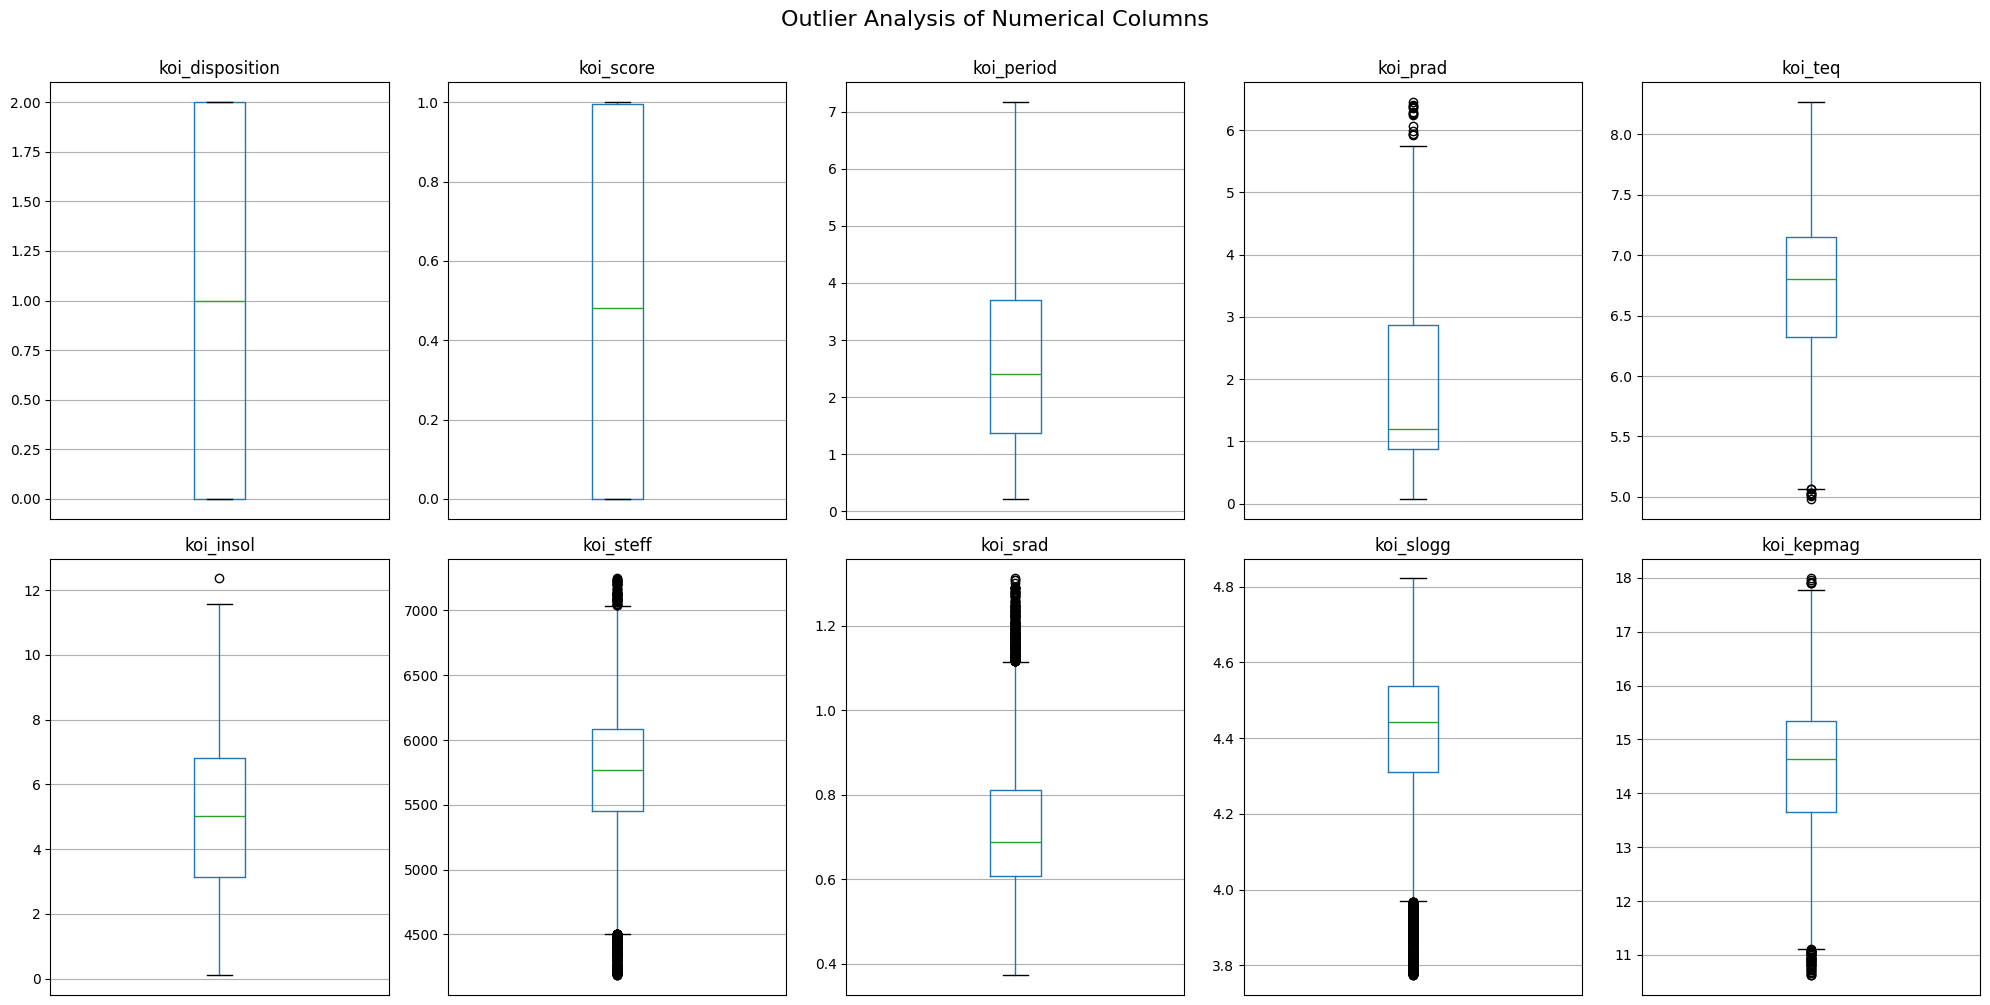

In [10]:
# Remove the outliers from the main dataset
outlier_columns = [col for col in df_transformed.columns if col.endswith("_outlier")]

df_clean_transform = df_transformed[~df_transformed[outlier_columns].any(axis=1)]
df_clean_transform = df_clean_transform.drop(columns=outlier_columns)

print("Cleaned dataset shape with np.log1p transform:", df_clean_transform.shape)

plot_outliers(df_clean_transform.select_dtypes(include=["float64", "int64"]).drop("kepid", axis=1), 2, 5, (20, 10))

### Part 2: Training models for predicting the status of the exoplanet candidate
For this part, I'll choose Random Forest and MLP for predicting if a POTENTIAL candidate (1) is either CONFIRMED (2) or FALSE POSITIVE (0).

In [11]:
# Based on data analysis (very high correlation), we can drop the following columns: koi_score, koi_teq and koi_slogg
final_df = df_clean_transform.drop(columns=["koi_score", "koi_teq", "koi_slogg"])
final_df

,kepid,kepoi_name,koi_disposition,koi_period,koi_prad,koi_insol,koi_steff,koi_srad,koi_kepmag
0,10797460,K00752.01,2,2.350235,1.181727,4.549552,5455.0,0.655964,15.347
1,10797460,K00752.02,2,4.014911,1.342865,2.313525,5455.0,0.655964,15.347
2,10811496,K00753.01,1,3.039708,2.747271,3.696351,5853.0,0.624868,15.436
3,10848459,K00754.01,0,1.006845,3.539799,6.794542,5805.0,0.582774,15.597
4,10854555,K00755.01,2,1.260048,1.321756,6.832126,6031.0,0.715887,15.509
...,...,...,...,...,...,...,...,...,...
9558,10031643,K07984.01,0,2.260707,0.746688,5.178407,5638.0,0.736207,14.478
9559,10090151,K07985.01,0,0.423762,3.412797,8.412173,5638.0,0.643432,14.082
9560,10128825,K07986.01,1,1.007903,0.542324,7.369481,6119.0,0.708528,14.757
9561,10147276,K07987.01,0,0.519628,0.727549,8.650746,6173.0,0.713440,15.385


In [12]:
# Splitting the dataset into training and testing sets
train_df = final_df[final_df["koi_disposition"] != 1]
test_df = final_df[final_df["koi_disposition"] == 1]

print("Training set samples:", train_df.shape[0])
print("Testing set samples:", test_df.shape[0])

Training set samples: 6511
Testing set samples: 1705


In [13]:
# Preparing the training and testing data
X_train, X_val, y_train, y_val = train_test_split(
    train_df.drop(columns=["kepid", "kepoi_name", "koi_disposition"]),
    train_df["koi_disposition"].map({0: 0, 2: 1}),
    test_size=0.2,
    random_state=42
)
X_test = test_df.drop(columns=["kepid", "kepoi_name", "koi_disposition"])

encoding_to_label = {
    0: "FALSE POSITIVE",
    1: "CONFIRMED"
}

# Scaling the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)

X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values.reshape(-1, 1), dtype=torch.float32)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

# Initializing the DataLoader
batch_size = 128
dataset_loaders = {
    "train": DataLoader(list(zip(X_train_tensor, y_train_tensor)), batch_size=batch_size, shuffle=True, pin_memory=True),
    "val": DataLoader(list(zip(X_val_tensor, y_val_tensor)), batch_size=batch_size, shuffle=False, pin_memory=True),
    "test": DataLoader(X_test_tensor, batch_size=batch_size, shuffle=False, pin_memory=True)
}

#### 2.1: Random Forest Classifier

In [14]:
def search_best_hiperparameters(model, parameters, inputs, labels, scoring):
    random_search = RandomizedSearchCV(model, parameters, scoring=scoring, n_jobs=-1, refit="accuracy", cv=5, random_state=42)
    random_search.fit(inputs, labels)
    print(f"Best parameters: {random_search.best_params_}")

    results = random_search.cv_results_

    return (
        random_search.best_estimator_,
        pd.DataFrame({
            "Parameters": results["params"],
            "Mean accuracy": results["mean_test_accuracy"],
            "Mean precision": results["mean_test_precision_macro"],
            "Mean recall": results["mean_test_recall_macro"],
            "Mean F1-score": results["mean_test_f1_macro"]
        })
    )

In [15]:
def sklearn_predict(model, inputs, pretrained=False):
    if not pretrained:
        model.fit(X_train, y_train)
    predictions = model.predict(inputs)
    return predictions

In [16]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)

    threshold = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > threshold else "black")

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

In [17]:
def sklearn_evaluate(model, model_description, inputs, labels, pretrained=False):
    if not pretrained:
        model.fit(X_train, y_train)
    predictions = model.predict(inputs)
    print(f"{model_description} classification report:")
    print(classification_report(labels, predictions, target_names=encoding_to_label.values(), digits=3))
    plot_confusion_matrix(labels, predictions, encoding_to_label.values())

In [18]:
# Defining the model
random_forest_model = RandomForestClassifier()

# Defining some test parameters
parameters = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "max_features": ["auto", "sqrt", "log2"]
}

# Defining scoring metrics
scoring = ["accuracy", "precision_macro", "recall_macro", "f1_macro"]

# Searching for the best parameters
random_forest_model, search_results = search_best_hiperparameters(random_forest_model, parameters, X_train, y_train, scoring)
search_results

Best parameters: {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 30}


,Parameters,Mean accuracy,Mean precision,Mean recall,Mean F1-score
0,"{'n_estimators': 200, 'max_features': 'log2', ...",0.871927,0.862382,0.867236,0.864597
1,"{'n_estimators': 100, 'max_features': 'sqrt', ...",0.864247,0.853627,0.865305,0.858044
2,"{'n_estimators': 200, 'max_features': 'log2', ...",0.869814,0.860082,0.865239,0.862429
3,"{'n_estimators': 50, 'max_features': 'sqrt', '...",0.871543,0.862696,0.864813,0.863622
4,"{'n_estimators': 100, 'max_features': 'log2', ...",0.862135,0.851390,0.862300,0.855650
5,"{'n_estimators': 100, 'max_features': 'sqrt', ...",0.872311,0.863107,0.866538,0.864699
6,"{'n_estimators': 50, 'max_features': 'sqrt', '...",0.867125,0.857476,0.861773,0.859384
7,"{'n_estimators': 50, 'max_features': 'sqrt', '...",0.862327,0.851565,0.862654,0.855904
8,"{'n_estimators': 200, 'max_features': 'log2', ...",0.871158,0.861665,0.866115,0.863689
9,"{'n_estimators': 200, 'max_features': 'log2', ...",0.865208,0.854556,0.865370,0.858823


Random Forest classification report:
                precision    recall  f1-score   support

FALSE POSITIVE      0.897     0.890     0.894       784
     CONFIRMED      0.836     0.846     0.841       519

      accuracy                          0.873      1303
     macro avg      0.867     0.868     0.867      1303
  weighted avg      0.873     0.873     0.873      1303



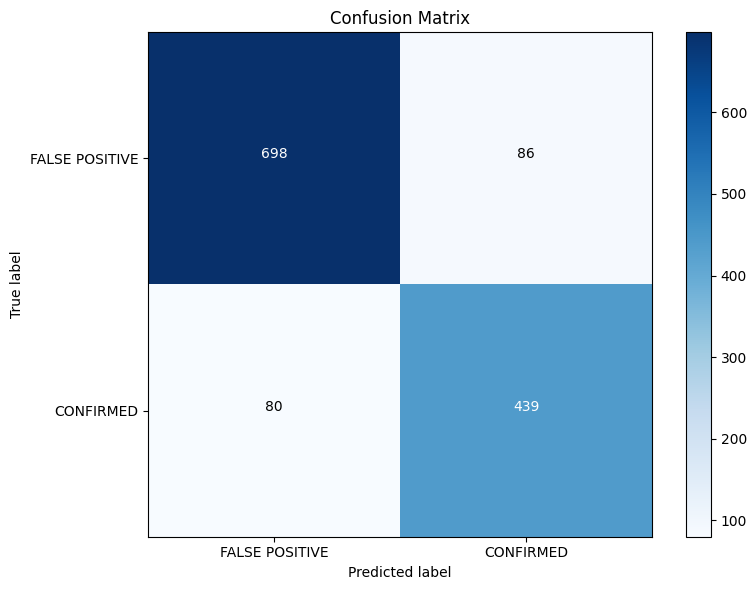

In [19]:
sklearn_evaluate(random_forest_model, "Random Forest", X_val, y_val, pretrained=True)

#### 2.2: Multi-Layer Perceptron

In [20]:
# Prerequisite for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for this notebook.")

Using cuda for this notebook.


In [21]:
def train_torch_model(model, model_description, dataloaders, params, device=torch.device("cpu")):
    criterion = params["criterion"]
    optimizer = params["optimizer"]
    scheduler = params.get("scheduler", None)
    epochs = params["epochs"]
    patience = params["patience"]

    model = model.to(device)

    train_loss_history, val_loss_history = [], []
    train_accuracy_history, val_accuracy_history = [], []

    # Initializing early stopping variables
    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(epochs):
        print("-" * 64)
        print(f"Epoch {epoch + 1}/{epochs}")

        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for inputs, labels in dataloaders["train"]:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).long().squeeze()
            labels = labels.long().squeeze()
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

        # Saving metrics for plotting later on
        epoch_train_loss = train_loss / len(dataloaders["train"])
        epoch_train_accuracy = train_correct / train_total
        train_loss_history.append(epoch_train_loss)
        train_accuracy_history.append(epoch_train_accuracy)

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in dataloaders["val"]:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                predicted = (torch.sigmoid(outputs) > 0.5).long().squeeze()
                labels = labels.long().squeeze()
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        # Saving metrics for plotting later on
        epoch_val_loss = val_loss / len(dataloaders["val"])
        epoch_val_accuracy = val_correct / val_total
        val_loss_history.append(epoch_val_loss)
        val_accuracy_history.append(epoch_val_accuracy)

        print(f"Train Loss: {epoch_train_loss:.6f}, Train Accuracy: {epoch_train_accuracy:.6f}")
        print(f"Val Loss:   {epoch_val_loss:.6f}, Val Accuracy:   {epoch_val_accuracy:.6f}")

        if scheduler:
            scheduler.step(epoch_val_loss)

        # Early stopping logic
        if epoch_val_loss < best_val_loss:
            best_model_state = model.state_dict()
            best_val_loss = epoch_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                model.load_state_dict(best_model_state)
                print("Early stopping triggered.")
                break

    return {
        "model_description": model_description,
        "train_losses": train_loss_history,
        "val_losses": val_loss_history,
        "train_accuracies": train_accuracy_history,
        "val_accuracies": val_accuracy_history
    }

In [22]:
def plot_metrics(metrics):
    _, axes = plt.subplots(1, 2, figsize=(20, 5))

    for metric in metrics:
        model_description = metric["model_description"]
        train_loss_history = metric["train_losses"]
        val_loss_history = metric["val_losses"]
        train_accuracy_history = metric["train_accuracies"]
        val_accuracy_history = metric["val_accuracies"]

        axes[0].plot(train_loss_history, label=f"Training ({model_description})")
        axes[0].plot(val_loss_history, label=f"Validation ({model_description})")
        axes[0].set_title("Loss history")
        axes[0].set_xlabel("Epochs")
        axes[0].set_ylabel("Loss")
        axes[0].legend()

        axes[1].plot(train_accuracy_history, label=f"Training ({model_description})")
        axes[1].plot(val_accuracy_history, label=f"Validation ({model_description})")
        axes[1].set_title("Accuracy history")
        axes[1].set_xlabel("Epochs")
        axes[1].set_ylabel("Accuracy")
        axes[1].legend()

    plt.show()

In [23]:
def torch_evaluate(model, description, dataloader, device=torch.device("cpu")):
    y_true = []
    y_pred = []

    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            predictions = (torch.sigmoid(outputs) > 0.5).long().squeeze()

            y_pred.extend(predictions.view(-1).cpu().numpy())
            y_true.extend(labels.view(-1).cpu().numpy())

    labels_list = [encoding_to_label[i] for i in np.unique(y_true)]
    print(f"{description} classification report:\n{classification_report(y_true, y_pred, target_names=labels_list, digits=3)}")
    plot_confusion_matrix(y_true, y_pred, labels_list)

In [24]:
def torch_predict(model, test_loader, device=torch.device("cpu")):
    model = model.to(device)
    model.eval()
    predictions = []

    with torch.no_grad():
        for inputs in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probabilities = (torch.sigmoid(outputs) > 0.5).long().squeeze()
            predictions.extend(probabilities.cpu().numpy())

    return np.array(predictions)

MLP_Lite(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)
----------------------------------------------------------------
Epoch 1/300
Train Loss: 0.722162, Train Accuracy: 0.516897
Val Loss:   0.699319, Val Accuracy:   0.544129
----------------------------------------------------------------
Epoch 2/300
Train Loss: 0.698783, Train Accuracy: 0.548771
Val Loss:   0.681317, Val Accuracy:   0.562548
----------------------------------------------------------------
Epoch 3/300
Train Loss: 0.687490, Train Accuracy: 0.569892
Val Loss:   0.668264, Val Accuracy:   0.594781
----------------------------------------------------------------
Epoch 4/300
Train Loss: 0.673744, Train Accuracy: 0.581989
Val Loss:   0.655080, Val Accuracy:   0.613968
-----------------

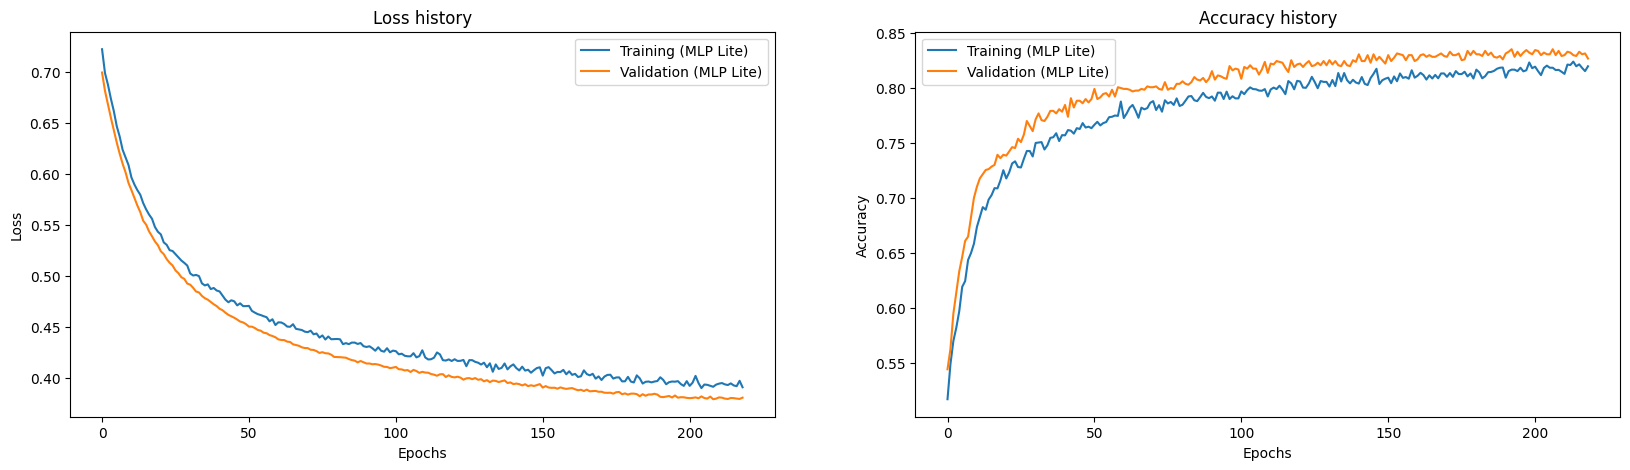

Train classification report:
                precision    recall  f1-score   support

FALSE POSITIVE      0.870     0.857     0.864      3245
     CONFIRMED      0.770     0.788     0.779      1963

      accuracy                          0.831      5208
     macro avg      0.820     0.823     0.821      5208
  weighted avg      0.832     0.831     0.832      5208



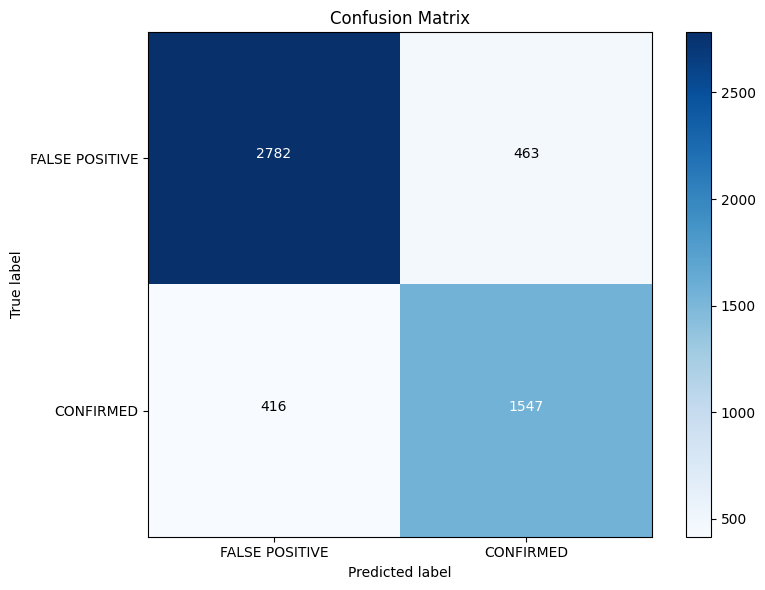

Validation classification report:
                precision    recall  f1-score   support

FALSE POSITIVE      0.849     0.866     0.857       784
     CONFIRMED      0.791     0.767     0.779       519

      accuracy                          0.827      1303
     macro avg      0.820     0.816     0.818      1303
  weighted avg      0.826     0.827     0.826      1303



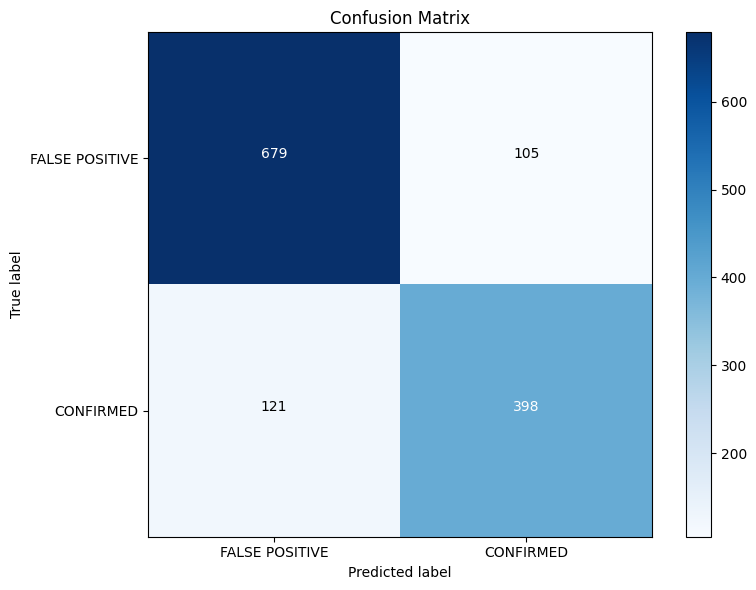

In [25]:
class MLP_Lite(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

mlp_lite_model = MLP_Lite(X_train.shape[1])
print(mlp_lite_model)

mlp_lite_train_params = {
    "criterion": nn.BCEWithLogitsLoss(),
    "optimizer": torch.optim.Adam(mlp_lite_model.parameters(), lr=5e-5),
    "epochs": 300,
    "patience": 10
}
mlp_lite_train_params["scheduler"] = torch.optim.lr_scheduler.ReduceLROnPlateau(mlp_lite_train_params["optimizer"], mode='min', patience=5, factor=0.5)

mlp_lite_metrics = train_torch_model(mlp_lite_model, "MLP Lite", dataset_loaders, mlp_lite_train_params, device)
plot_metrics([mlp_lite_metrics])
torch_evaluate(mlp_lite_model, "Train", dataset_loaders["train"], device)
torch_evaluate(mlp_lite_model, "Validation", dataset_loaders["val"], device)

MLP_Medium(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)
----------------------------------------------------------------
Epoch 1/300
Train Loss: 0.667716, Train Accuracy: 0.580069
Val Loss:   0.648038, Val Accuracy:   0.728319
----------------------------------------------------------------
Epoch 2/300
Train Loss: 0.636527, Train Accuracy: 0.626920
Val Loss:   0.620021, Val Accuracy:   0.770530
----------------------------------------------------------------
Epoch 3/300
Train Loss: 0.617832, Train Accuracy: 0.658986
Val Loss:   0.596378, Val 

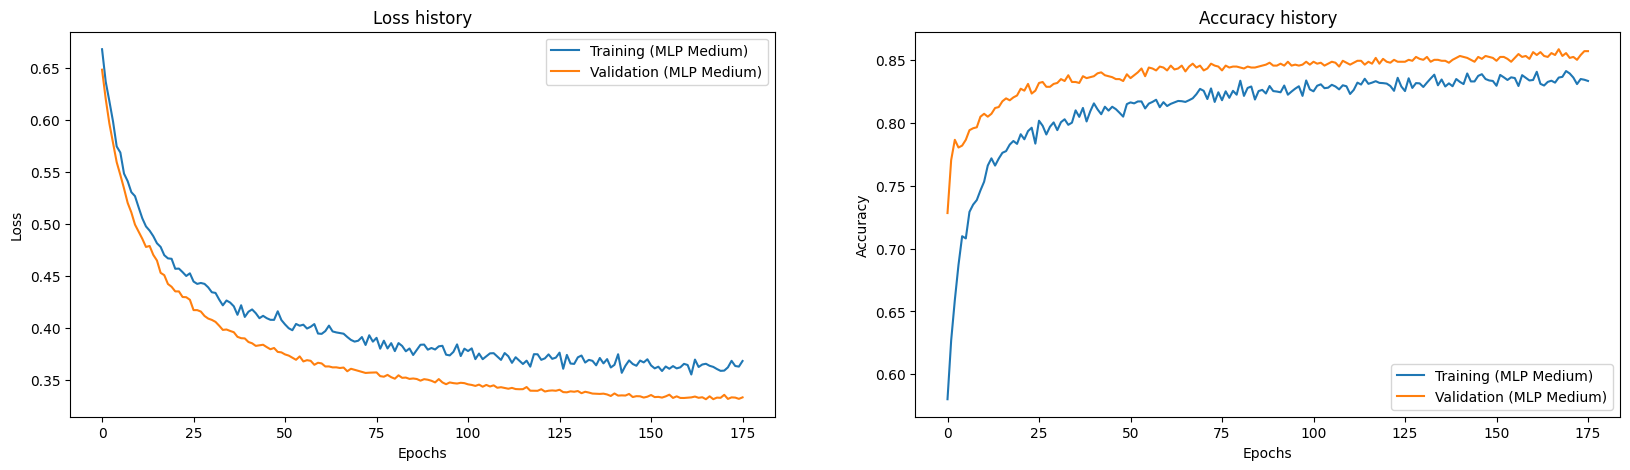

Train classification report:
                precision    recall  f1-score   support

FALSE POSITIVE      0.932     0.827     0.876      3245
     CONFIRMED      0.759     0.901     0.824      1963

      accuracy                          0.855      5208
     macro avg      0.846     0.864     0.850      5208
  weighted avg      0.867     0.855     0.857      5208



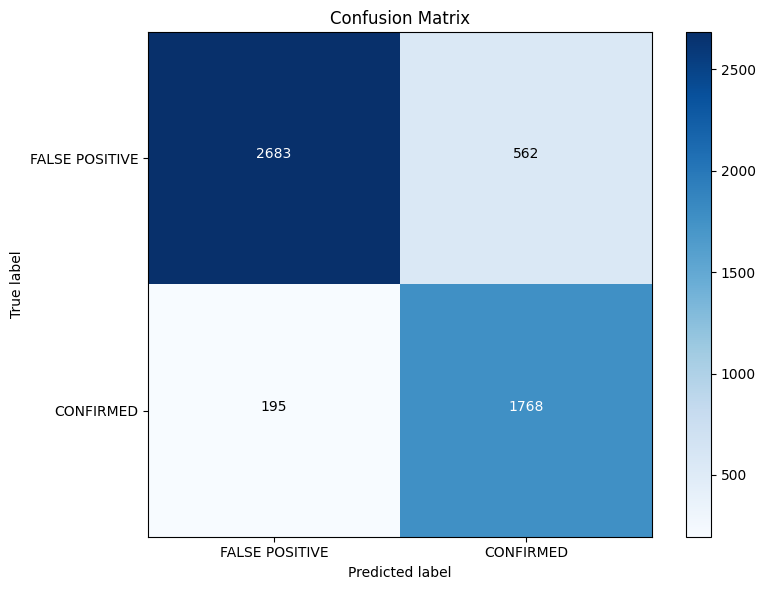

Validation classification report:
                precision    recall  f1-score   support

FALSE POSITIVE      0.918     0.838     0.876       784
     CONFIRMED      0.784     0.886     0.832       519

      accuracy                          0.857      1303
     macro avg      0.851     0.862     0.854      1303
  weighted avg      0.864     0.857     0.858      1303



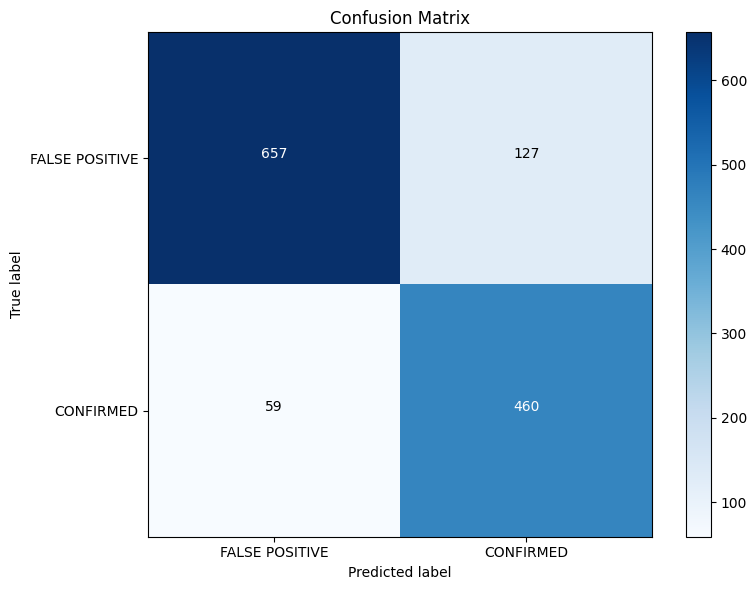

In [26]:
class MLP_Medium(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

mlp_medium_model = MLP_Medium(X_train.shape[1])
print(mlp_medium_model)

mlp_medium_train_params = {
    "criterion": nn.BCEWithLogitsLoss(),
    "optimizer": torch.optim.Adam(mlp_medium_model.parameters(), lr=5e-5),
    "epochs": 300,
    "patience": 10
}
mlp_medium_train_params["scheduler"] = torch.optim.lr_scheduler.ReduceLROnPlateau(mlp_medium_train_params["optimizer"], mode='min', patience=5, factor=0.5)

mlp_medium_metrics = train_torch_model(mlp_medium_model, "MLP Medium", dataset_loaders, mlp_medium_train_params, device)
plot_metrics([mlp_medium_metrics])
torch_evaluate(mlp_medium_model, "Train", dataset_loaders["train"], device)
torch_evaluate(mlp_medium_model, "Validation", dataset_loaders["val"], device)

MLP_Deep(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=1, bias=True)
  )
)
----------------------------------------------------------------
Epoch 1/300
Train Loss: 0.656083, Train Accuracy: 0.618088
Val Loss:   0.628221, Val Accuracy:   0.755948
----------------------------------------------------------------
Epoch 2/300
Train Loss: 0.613096, Train Accuracy

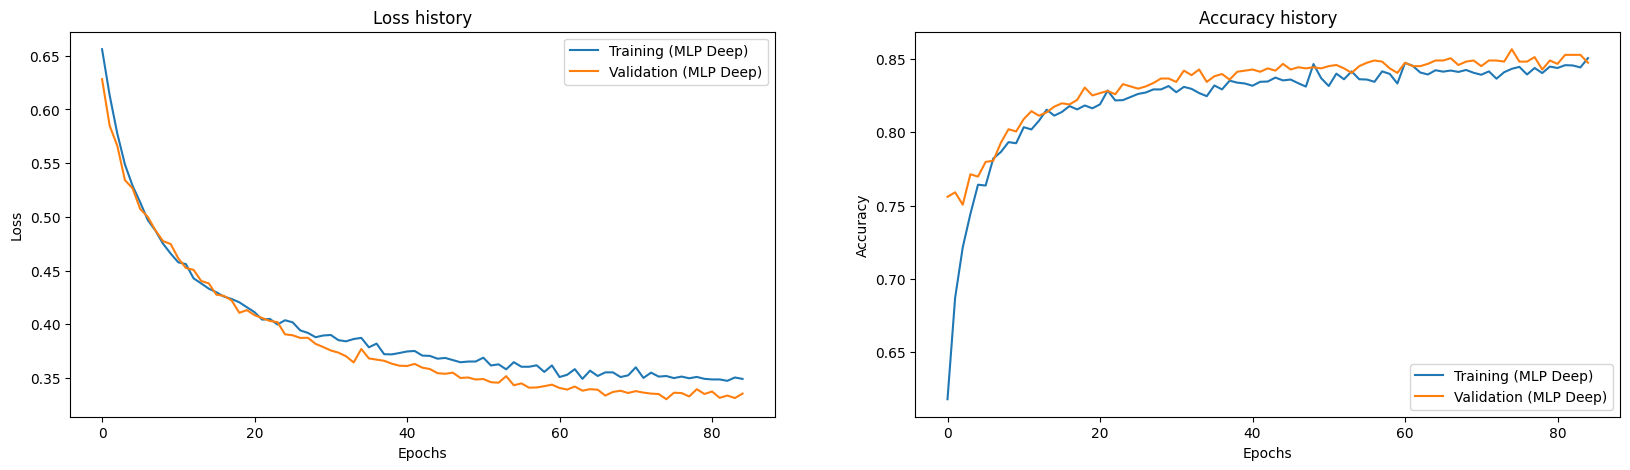

Train classification report:
                precision    recall  f1-score   support

FALSE POSITIVE      0.942     0.803     0.867      3245
     CONFIRMED      0.738     0.919     0.819      1963

      accuracy                          0.847      5208
     macro avg      0.840     0.861     0.843      5208
  weighted avg      0.866     0.847     0.849      5208



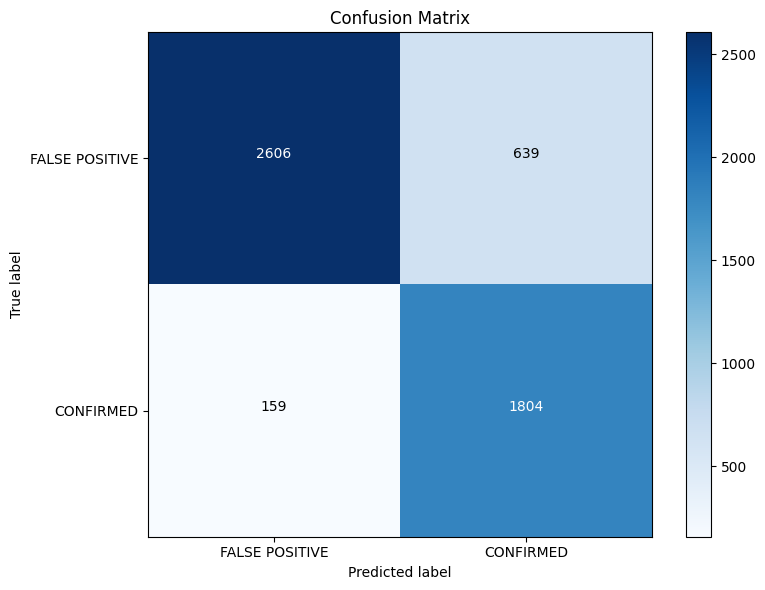

Validation classification report:
                precision    recall  f1-score   support

FALSE POSITIVE      0.933     0.804     0.864       784
     CONFIRMED      0.755     0.913     0.827       519

      accuracy                          0.847      1303
     macro avg      0.844     0.858     0.845      1303
  weighted avg      0.862     0.847     0.849      1303



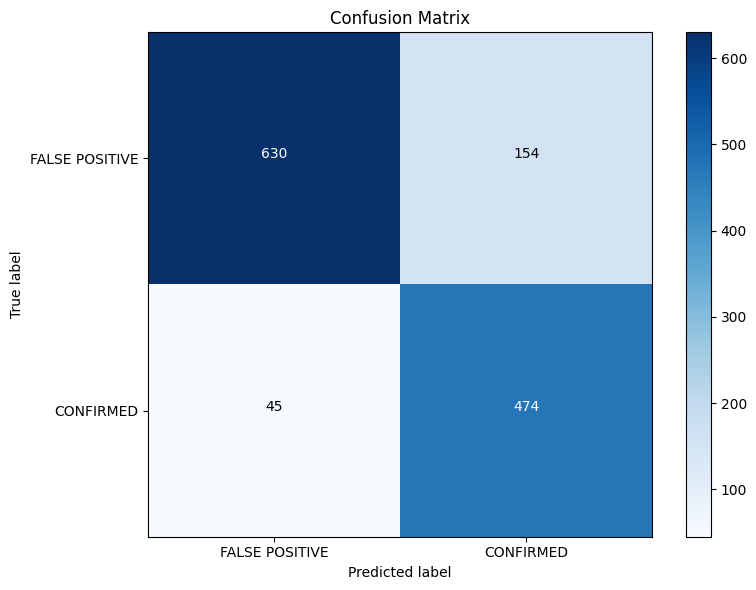

In [27]:
class MLP_Deep(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

mlp_deep_model = MLP_Deep(X_train.shape[1])
print(mlp_deep_model)

mlp_deep_train_params = {
    "criterion": nn.BCEWithLogitsLoss(),
    "optimizer": torch.optim.Adam(mlp_deep_model.parameters(), lr=5e-5),
    "epochs": 300,
    "patience": 10
}
mlp_deep_train_params["scheduler"] = torch.optim.lr_scheduler.ReduceLROnPlateau(mlp_deep_train_params["optimizer"], mode='min', patience=5, factor=0.5)

mlp_deep_metrics = train_torch_model(mlp_deep_model, "MLP Deep", dataset_loaders, mlp_deep_train_params, device)
plot_metrics([mlp_deep_metrics])
torch_evaluate(mlp_deep_model, "Train", dataset_loaders["train"], device)
torch_evaluate(mlp_deep_model, "Validation", dataset_loaders["val"], device)

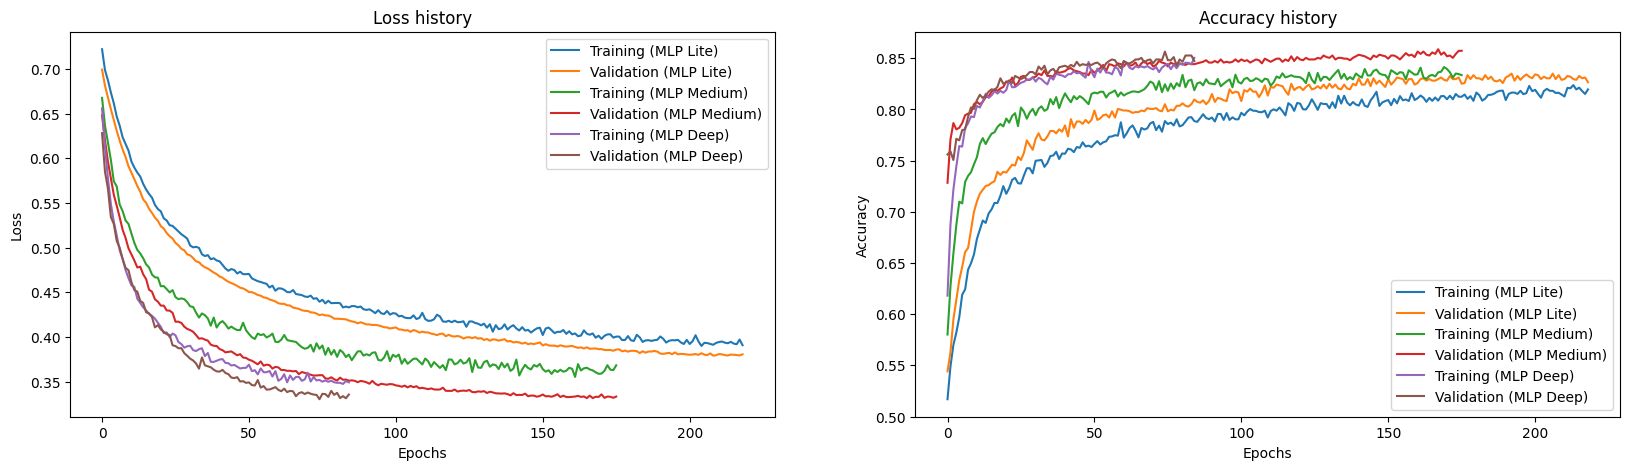

In [28]:
plot_metrics([mlp_lite_metrics, mlp_medium_metrics, mlp_deep_metrics])

#### 2.3: Predicting CANDIDATES as either FALSE POSITIVES (0) or CONFIRMED (1) using the above trained models

In [29]:
# Using Random Forest for predictions
y_test_random_forest = sklearn_predict(random_forest_model, X_test, pretrained=True)

# Using MLP Deep for predictions
y_test_mlp_deep = torch_predict(mlp_deep_model, dataset_loaders["test"], device)

test_df_with_predictions = df_clean_transform[df_clean_transform["koi_disposition"] == 1].copy()
test_df_with_predictions["RandomForest_Pred"] = y_test_random_forest
test_df_with_predictions["MLP_Pred"] = y_test_mlp_deep
test_df_with_predictions

,kepid,kepoi_name,koi_disposition,koi_score,koi_period,koi_prad,koi_teq,koi_insol,koi_steff,koi_srad,koi_slogg,koi_kepmag,RandomForest_Pred,MLP_Pred
2,10811496,K00753.01,1,0.000,3.039708,2.747271,6.459904,3.696351,5853.0,0.624868,4.544,15.436,0,0
58,11818800,K00777.01,1,0.999,3.723752,2.141242,6.148468,2.508786,5446.0,0.577175,4.507,15.487,1,1
62,11918099,K00780.02,1,0.993,2.109081,3.017983,6.599870,4.243196,5005.0,0.568151,4.595,15.334,0,0
63,9579641,K00115.03,1,0.871,1.489734,0.438255,7.149132,6.427475,5779.0,0.735728,4.339,12.791,0,1
84,3115833,K00797.01,1,1.000,2.414268,2.166765,6.700731,4.643525,5988.0,0.607589,4.541,15.657,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9523,2284957,K08085.01,1,0.416,6.040877,0.993252,5.549076,0.703098,5979.0,0.680568,4.379,14.547,0,0
9538,9938836,K07978.01,1,0.843,2.112415,0.978326,7.275865,6.936294,6297.0,1.169071,3.890,13.729,1,1
9542,10011213,K07982.01,1,0.189,5.933252,1.449269,5.583496,0.770108,6231.0,0.670390,4.488,15.632,0,0
9552,10028127,K08193.01,1,0.519,5.910655,1.551809,5.433722,0.494696,5570.0,0.617885,4.561,15.719,0,0
